## Análisis bivariado

El análisis exploratorio bivariado se realiza con dos objetivos. Por un lado, se busca encontrar patrones entre la variable a predecir y los predictores que nos sugieran rasgos que podríamos encontrar en las estimaciones de modelos de predicción. Por otra parte, también clarifica la forma de utilización de las variables y echa luz acerca de la relación entre ellas. Esto último puede servir para posibles estrategias de simplificación de información (cluster de variabes para reducir la complejidad del dataset), como la forma en que ingresamos los *inputs* al modelo.   

La sección se inicia igual que el apartado anterior de análisis bivariado, primero cargamos las liberías que utilizamos junto con el dataset armado en la sección de preparación de datos. A su vez, creamos la clase *style* que se utilizará para darle colores a los `prints` realizados en las líneas de código. Nuevamente, el análisis se realiza sobre el subconjunto de entrenamiento por las razones explicadas antes. 

In [42]:
# cargamos las librerías
import pandas as pd 
import numpy as np  
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from statsmodels.graphics.tsaplots import plot_pacf
from datetime import datetime, timedelta 
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl
import seaborn as sns
from seaborn import distplot
import scipy as scp
# muteamos algunos warnings esperables que no afectan los outputs de los códigos
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [43]:
# creamos la clase style para poner colores a los prints
class style():
    black = '\033[30m'
    red = '\033[31m'
    green = '\033[1;32m' # bold
    underline = '\033[4m'
    mark = '\33[44m'
    endc = '\033[0m'

In [44]:
# importamos dataset
aux = 'https://drive.google.com/file/d/1GWaKdMRk4Fx9qGgBMioNeO3E7_I3bA8k/view?usp=sharing'
link ='https://drive.google.com/uc?id=' + aux.split('/')[-2]
df = pd.read_csv(link)
df = df.set_index('Date')

# subconjunto a utilizar: dataset de entrenamiento
start = df.index[0]
# Enfoque de validación
train = df[start:'2020-12-31']
train.head()

,Volume USDT_btc,cryptocurrency_adjusted,crypto_adjusted,bitcoin_adjusted,bitcoin price_adjusted,ethereum_adjusted,ethereum price_adjusted,stock market_adjusted,wall street_adjusted,interest rate_adjusted,...,y_lag4,y_lag5,y_lag6,y_lag7,unix_btc,open_btc,high_btc,low_btc,close_btc,Volume BTC_btc
Date,,,,,,,,,,,,,,,,,,,,,
2015-08-08,3.8010,0.0,0.48,1.74,0.27,0.0,0.0,1.45,8.32,16.38,...,2.150,1.825,1.310,1.645,1438992000,275.92,282.24,262.65,263.00,1032.69
2015-08-11,0.9435,0.0,0.88,1.89,0.49,0.0,0.0,2.61,9.92,19.74,...,1.825,1.310,1.645,1.520,1439251200,266.22,269.26,261.61,269.26,247.49
2015-08-12,2.5580,0.0,0.87,1.83,0.47,0.0,0.0,3.48,10.40,20.58,...,1.310,1.645,1.520,1.410,1439337600,269.26,275.63,263.33,265.41,682.19
2015-08-13,3.1890,0.0,0.87,1.95,0.35,0.0,0.0,2.61,10.40,18.48,...,1.645,1.520,1.410,1.515,1439424000,265.41,269.88,260.00,263.00,838.99
2015-08-14,2.1290,0.0,0.83,1.68,0.32,0.0,0.0,2.32,10.88,16.80,...,1.520,1.410,1.515,1.615,1439510400,263.00,265.00,255.00,265.00,556.23


### Correlación lineal

#### Target versus predictoras
En primer lugar realizamos un análisis de correlación lineal de pearson entre los diferentes rezagos del precio de ethereum y las variables predictoras. La idea detrás de esto es ver qué tan factible sería proyectar un ejercicio de predicción con ventanas temporales mayores a un día de diferencia entre los predictores y la dependiente, en nuestro caso, intentando predecir los siguiente siete días posteriores al momento corriente. De ser posible, la predicción permitiría tener una mirada más amplia de la evolución predicha de la cotización de ethereum, permitiendo al usuario del modelo conocer su evolución futura en un rango de tiempo futuro mayor al día posterior, brindandole un panorama más amplio para la toma de decisiones.   

Para realizar el análisis creamos un loop donde computamos las correlaciones entre cada target con cada uno de los predictores utilizados.Con motivos de simplificar el análisis, visualizamos el top 10 de las correlaciones entre el primer rezago del precio de etherum con los inputs y el séptimo rezago con los *features*. 

In [45]:
# Correlación entre las target y otras variables
columnas = train.columns #devuelve una lista con los nombres de las columnas
targets = ['y_lag1', 'y_lag2', 'y_lag3', 'y_lag4', 'y_lag5', 'y_lag6', 'y_lag7']
columnas = [e for e in columnas if e not in targets] # saco las variables a predecir
correlaciones = {}
for i in range(1,8):
  input = {}
  for c in columnas:
    corr = scp.stats.pearsonr(train[f'y_lag{i}'], train[c])[0]
    input[c] = corr
  correlaciones[f'y_lag{i}'] = input

In [46]:
# correlación lineal lag 1: top 10
df_corr_lag1 = pd.DataFrame(correlaciones['y_lag1'].items(), columns = ['Predictores', 'Correlacion'])
df_corr_lag1['corr_abs'] = abs(df_corr_lag1['Correlacion'])
df_corr_lag1.sort_values('corr_abs', ascending = False)[0:10]

,Predictores,Correlacion,corr_abs
37,close_eth,0.999110,0.999110
40,eth_close_open_mean,0.998156,0.998156
35,high_eth,0.997592,0.997592
36,low_eth,0.996777,0.996777
34,open_eth,0.995428,0.995428
2,crypto_adjusted,0.809500,0.809500
16,cryptocurrency_top_adjusted,0.792022,0.792022
1,cryptocurrency_adjusted,0.752407,0.752407
43,high_btc,0.749247,0.749247
42,open_btc,0.744810,0.744810


In [47]:
# correlación lineal lag 7: top 10
df_corr_lag7 = pd.DataFrame(correlaciones['y_lag7'].items(), columns = ['Predictores', 'Correlacion'])
df_corr_lag7['corr_abs'] = abs(df_corr_lag7['Correlacion'])
df_corr_lag7.sort_values('corr_abs', ascending = False)[0:10]

,Predictores,Correlacion,corr_abs
37,close_eth,0.973860,0.973860
40,eth_close_open_mean,0.972392,0.972392
35,high_eth,0.972092,0.972092
36,low_eth,0.970465,0.970465
34,open_eth,0.969195,0.969195
2,crypto_adjusted,0.798089,0.798089
16,cryptocurrency_top_adjusted,0.790043,0.790043
43,high_btc,0.768992,0.768992
42,open_btc,0.763182,0.763182
45,close_btc,0.762169,0.762169


Comparando ambas tablas, podemos ver que la correlación más alta, que es con la variable "close_eth" es de 0.999 para y_lag1 y 0.974 para y_lag7, un resultado esperable dado la alta autocorrelación parcial visto en el análisis univariado. No sólo eso, sino que el orden entre las correlaciones parecería mantenerse al ampliar la ventana temporal a predecir. De esto se desprenden algunos puntos a considerar en el análisis. Por un lado, existen variables como el precio de cierre diario de ethereum que tienen una correlación lineal casi perfecta al predecir la cotización del día siguiente y cuya asociación lineal solamente disminuye aproximadamente en 0.025 puntos al pasar de la cotización del rezago uno al séptimo, lo cual sigue siendo una correlación lineal sumamente alta. En segundo lugar, el orden de las asociaciones no varía de manera considerable al pasar entre ambas variables dependientes, lo cual sugiere la existencia de una relación casi lineal tanto entre los inputs y la cotización del primer rezago como con el séptimo rezado.A su vez, la información de ethereum como los distintos precios presentes tienen la mayor correlación con el target, por lo que considerar su cotización corriente es de suma importancia para la predicción. En tercer lugar, la alta correlación en ambas ventanas extremas genera un panorama alentador en términos de cuán lejos un modelo de predicción podría anticipar el precio futuro de ethereum. 

La variable *close_btc* aparece como una variable muy correlacionada con el precio de ethereum, sugiriendo lo que comentábamos en el archivo [**2.1 Análisis univariado**](https://colab.research.google.com/drive/1iqGw9KMUPGrJEMBnjgvQCGRqOvaNGE0G), acerca de la fuerte asociación entre el precio de bitcoin y ethereum. 

También para el análisis univariado seleccionamos las variables con el mayor promedio de búsquedas diario y dos de los de menor promedio, pensando en que podían tener relación con el precio de ethereum.  Las variables fueron: 'banking_adjusted', 'investment_top_adjusted', 'covid19_adjusted' y 'elon musk_adjusted'.

Como habíamos visto en ese análisis, no se veía dependencia clara entre la búsqueda de esas palabras y el precio de ethereum. Aquí lo podemos confirmar. De esas cuatro palabras, la que tiene mayor correlación con el precio de ethereum a predecir es *investment_top_adjusted* con 0.211 contra *y_lag1* y 0.21 contra *y_lag7*.

In [48]:
varL = ['investment_top_adjusted', 'banking_adjusted', 'elon musk_adjusted', 'covid19_adjusted']
for v in varL:
    cor_lag1 =  scp.stats.pearsonr(train.loc[:, 'y_lag1'], train.loc[:, v])[0]
    cor_lag7 =  scp.stats.pearsonr(train.loc[:, 'y_lag7'], train.loc[:, v])[0]
    print(f'{v}_lag1: {style.green}{round(cor_lag1, 3)}{style.endc}')
    print(f'{v}-y_lag7: {style.green}{round(cor_lag7, 3)}{style.endc}')

investment_top_adjusted_lag1: 0.211
investment_top_adjusted-y_lag7: 0.21
banking_adjusted_lag1: 0.134
banking_adjusted-y_lag7: 0.129
elon musk_adjusted_lag1: 0.135
elon musk_adjusted-y_lag7: 0.134
covid19_adjusted_lag1: 0.076
covid19_adjusted-y_lag7: 0.09


Retomando el análisis en la sección de análisis univariado, las variables "de momento" tienen la característica de que se podrían correlacionar fuertemente con el target en un período específico de tiempo, por lo que considerar las correlaciones en todo el período de estudio podría subestimar la influencia de estos predictores, como es el caso de la palabra *covid19* o *elon musk*, que podrían tener un rol importante en detectar patrones más volátiles en intervalos menores de tiempo. De hecho, al repetir el ejercicio de correlación entre la palabra *covid19* y el target *y_lag1* pero restringiendo el período de tiempo a marzo de 2020 - diciembre de 2020 se observa lo esperado.

In [49]:
cor_lag1 =  scp.stats.pearsonr(train.loc['2020-03-01':, 'y_lag1'], 
                               train.loc['2020-03-01':, 'covid19_adjusted'])[0]
cor_lag7 =  scp.stats.pearsonr(train.loc['2020-03-01':, 'y_lag7'], 
                               train.loc['2020-03-01':, 'covid19_adjusted'])[0]
print(f'covid-19_lag1: {style.green}{round(cor_lag1, 3)}{style.endc}')
print(f'covid-19-y_lag7: {style.green}{round(cor_lag7, 3)}{style.endc}')


covid-19_lag1: -0.48
covid-19-y_lag7: -0.414


Como se puede ver, la correlación aumenta considerablemente y su signo cambia. La magnitud pasa de 0.076 (signo positivo) en todo el período a 0.48 (signo negativo) entre el período relevante de la variable. De esta forma, la correlación indica que mayor frecuencia diaria de la palabra *covid 19* en google se asocia negativamente con la cotización del precio de ethereum, y su magnitud, como en el caso general, disminuye a mayor ventana temporal. 

#### Predictoras entre sí

Nos interesa realizar el análisis de la correlación entre predictoras ya que más adelante nos servirá para estudiar con mayor precisión las estimaciones con componentes principales.

Para esto, separaremos las variables "de momento" de las variables "regulares" considerando lo estudiado en el archivo [**2.1 Análisis univariado**](https://colab.research.google.com/drive/1iqGw9KMUPGrJEMBnjgvQCGRqOvaNGE0G). 

Poniendo como punto de corte para hacer la división en grupos que el promedio de frecuencia de búsqueda sea menor a 6.5, las palabras que componen el grupo "de momento" son:
'covid19_adjusted', 'pandemic_adjusted', 'elon musk_adjusted', 'russia_adjusted' y 'do kwon_adjusted'.

Las demás palabras componen al grupo "regular".


Comenzamos a estudiar la correlación entre las variables predictoras del grupo "regular", considerando solamente las palabras.

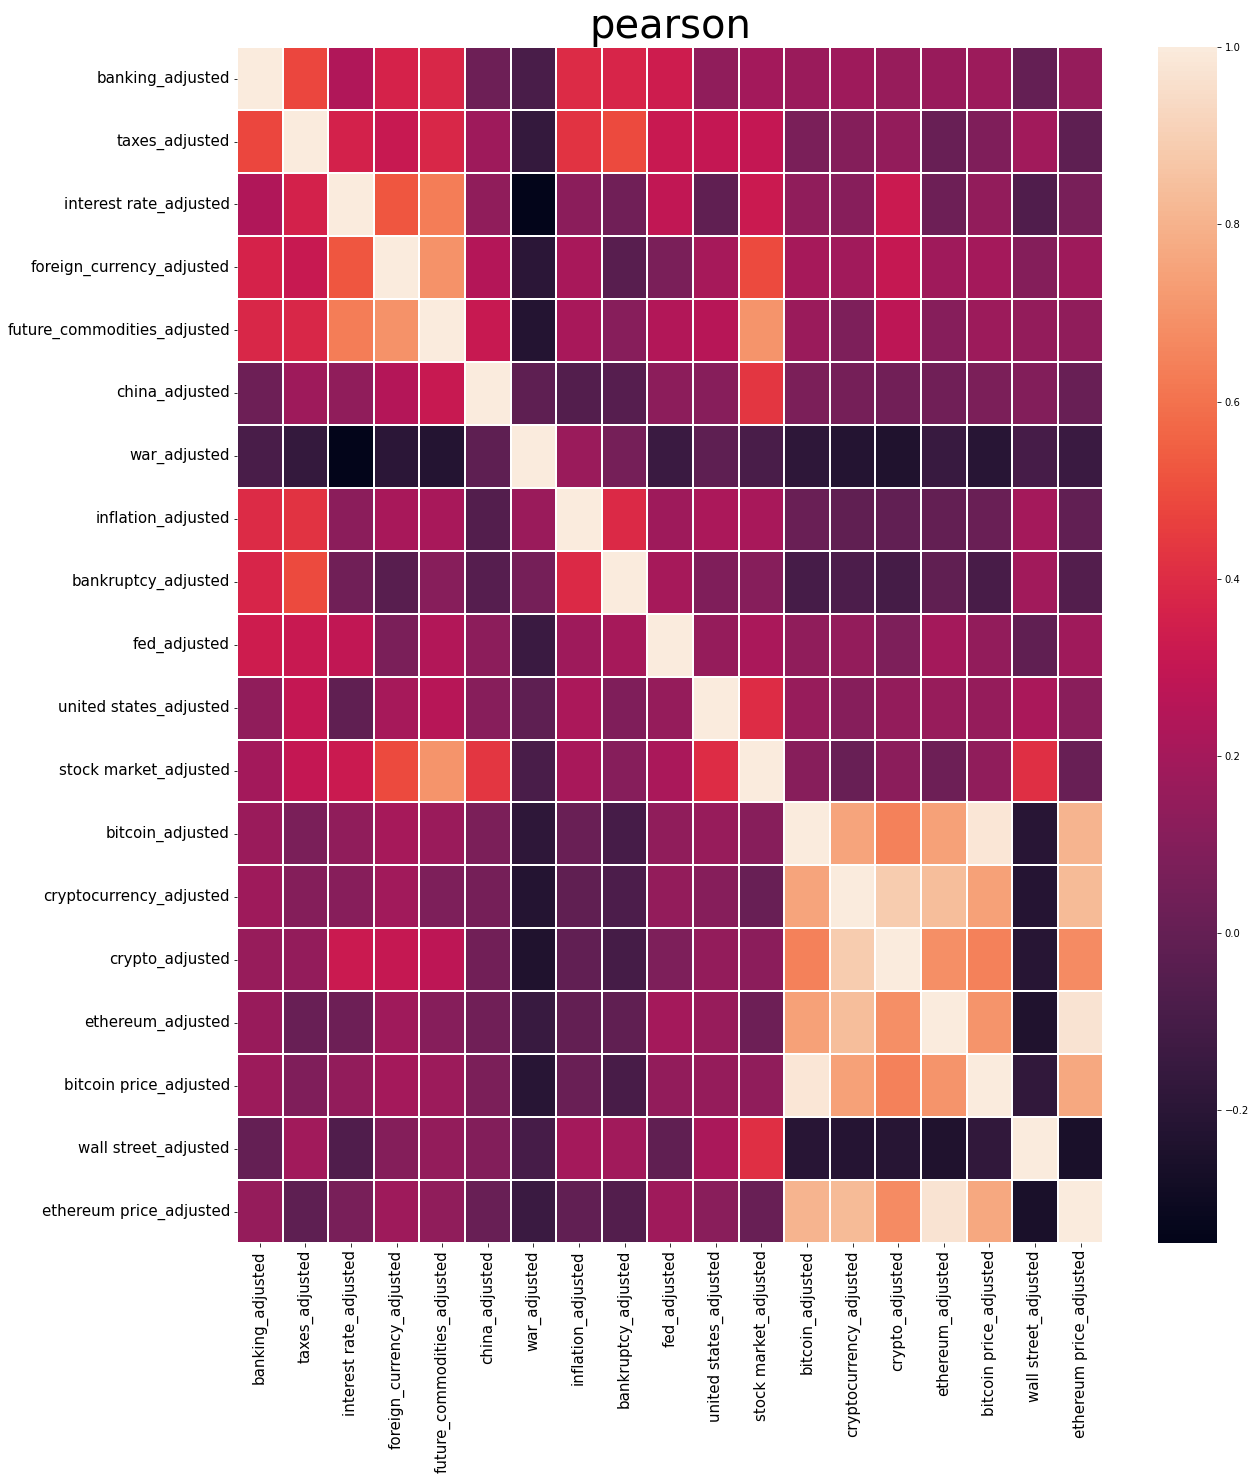

In [50]:
# seleccionamos las columnas de interés
train2 = train.loc[:,['banking_adjusted', 'taxes_adjusted', 'interest rate_adjusted', 'foreign_currency_adjusted', 'future_commodities_adjusted', 'china_adjusted', 'war_adjusted', 'inflation_adjusted', 'bankruptcy_adjusted', 'fed_adjusted', 'united states_adjusted', 'stock market_adjusted', 'bitcoin_adjusted', 'cryptocurrency_adjusted', 'crypto_adjusted', 'ethereum_adjusted', 'bitcoin price_adjusted', 'wall street_adjusted', 'ethereum price_adjusted']]
#generacion del grafico de correlacion
plt.figure(figsize=(66,22))
for j,i in enumerate(['pearson']):
  plt.subplot(1,3,j+1)
  correlation = train2.dropna().corr(method=i)
  sns.heatmap(correlation, linewidth = 1)
  plt.title(i, fontsize=40)
  plt.yticks(fontsize=15)
  plt.xticks(fontsize=15)

Como se puede observar en el gráfico, el grupo de variables 'bitcoin_adjusted', 'cryptocurrency_adjusted', 'crypto_adjusted', 'ethereum_adjusted', 'bitcoin price_adjusted' y 'ethereum price_adjusted' están muy correlacionadas entre sí, lo que era de esperarse.

Ahora realizaremos las correlaciones entre las búsquedas top dentro del grupo "regular".

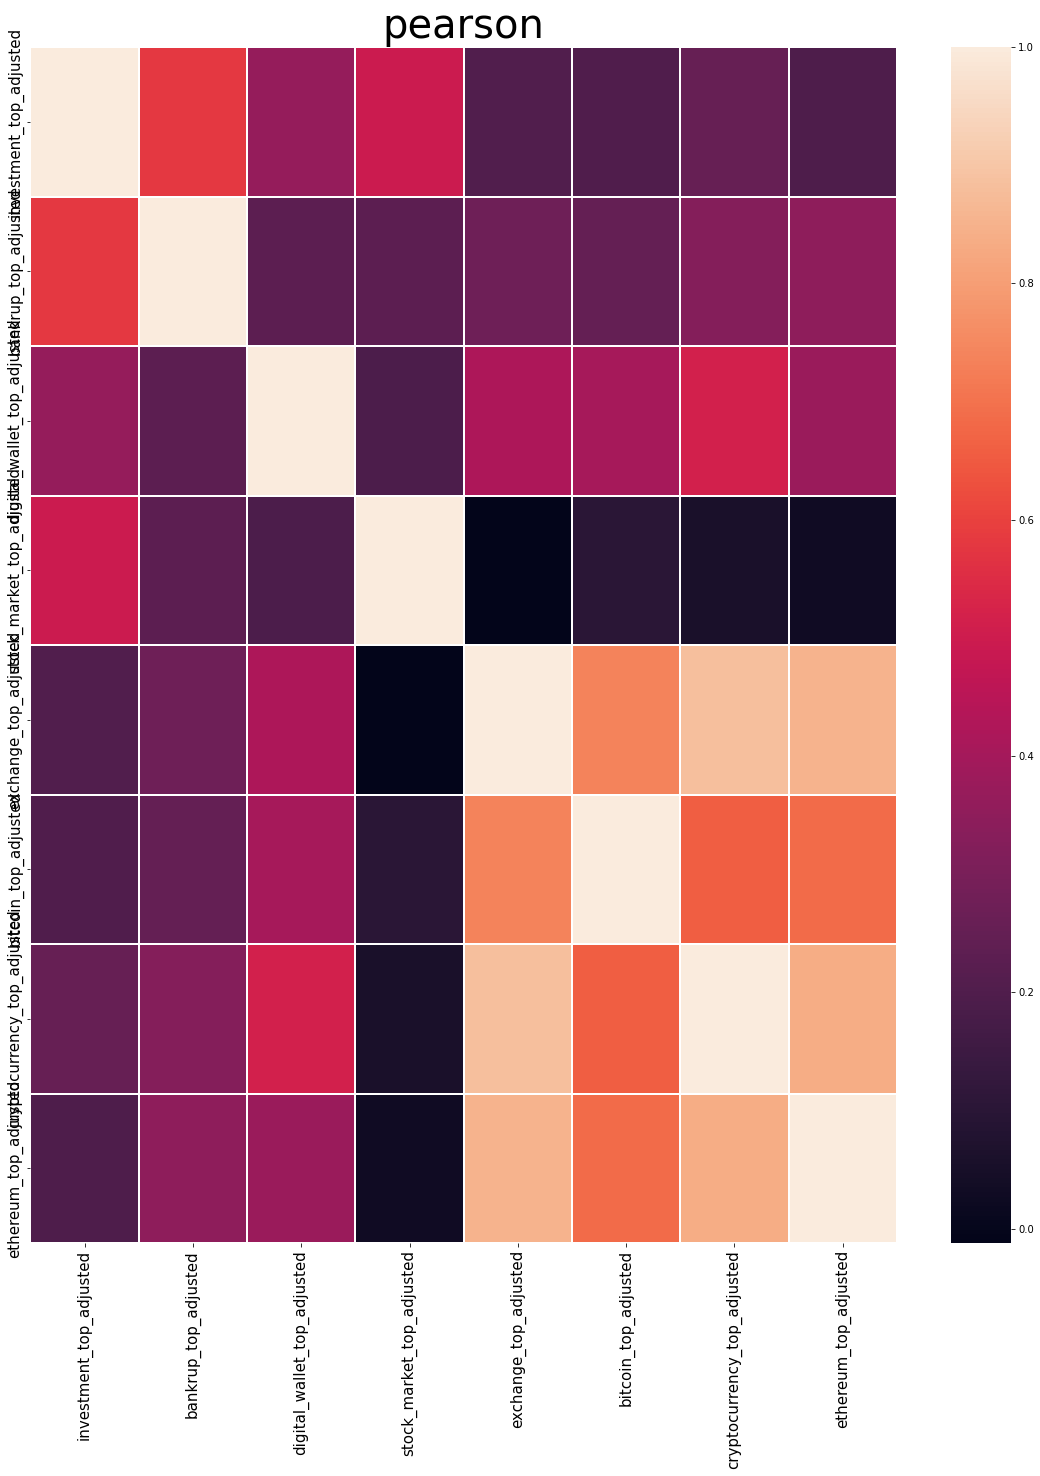

In [51]:
# seleccionamos las columnas de interés
train2 = train.loc[:,['investment_top_adjusted', 'bankrup_top_adjusted', 'digital_wallet_top_adjusted', 'stock_market_top_adjusted', 'exchange_top_adjusted', 'bitcoin_top_adjusted', 'cryptocurrency_top_adjusted', 'ethereum_top_adjusted']]
#generacion del grafico de correlacion 
plt.figure(figsize=(66,22))
for j,i in enumerate(['pearson']):
  plt.subplot(1,3,j+1)
  correlation = train2.dropna().corr(method=i)
  sns.heatmap(correlation, linewidth = 1)
  plt.title(i, fontsize=40)
  plt.yticks(fontsize=15)
  plt.xticks(fontsize=15)

Como es de esperarse, los top más correlacionados entre sí son 'exchange_top_adjusted', 'bitcoin_top_adjusted', 'cryptocurrency_top_adjusted' y 'ethereum_top_adjusted'.

Ahora observaremos las correlaciones entre las palabras más correlacionadas entre sí, los top más correlacionados entre sí y las variables de interés que se desprenden de los datos de Poloniex.

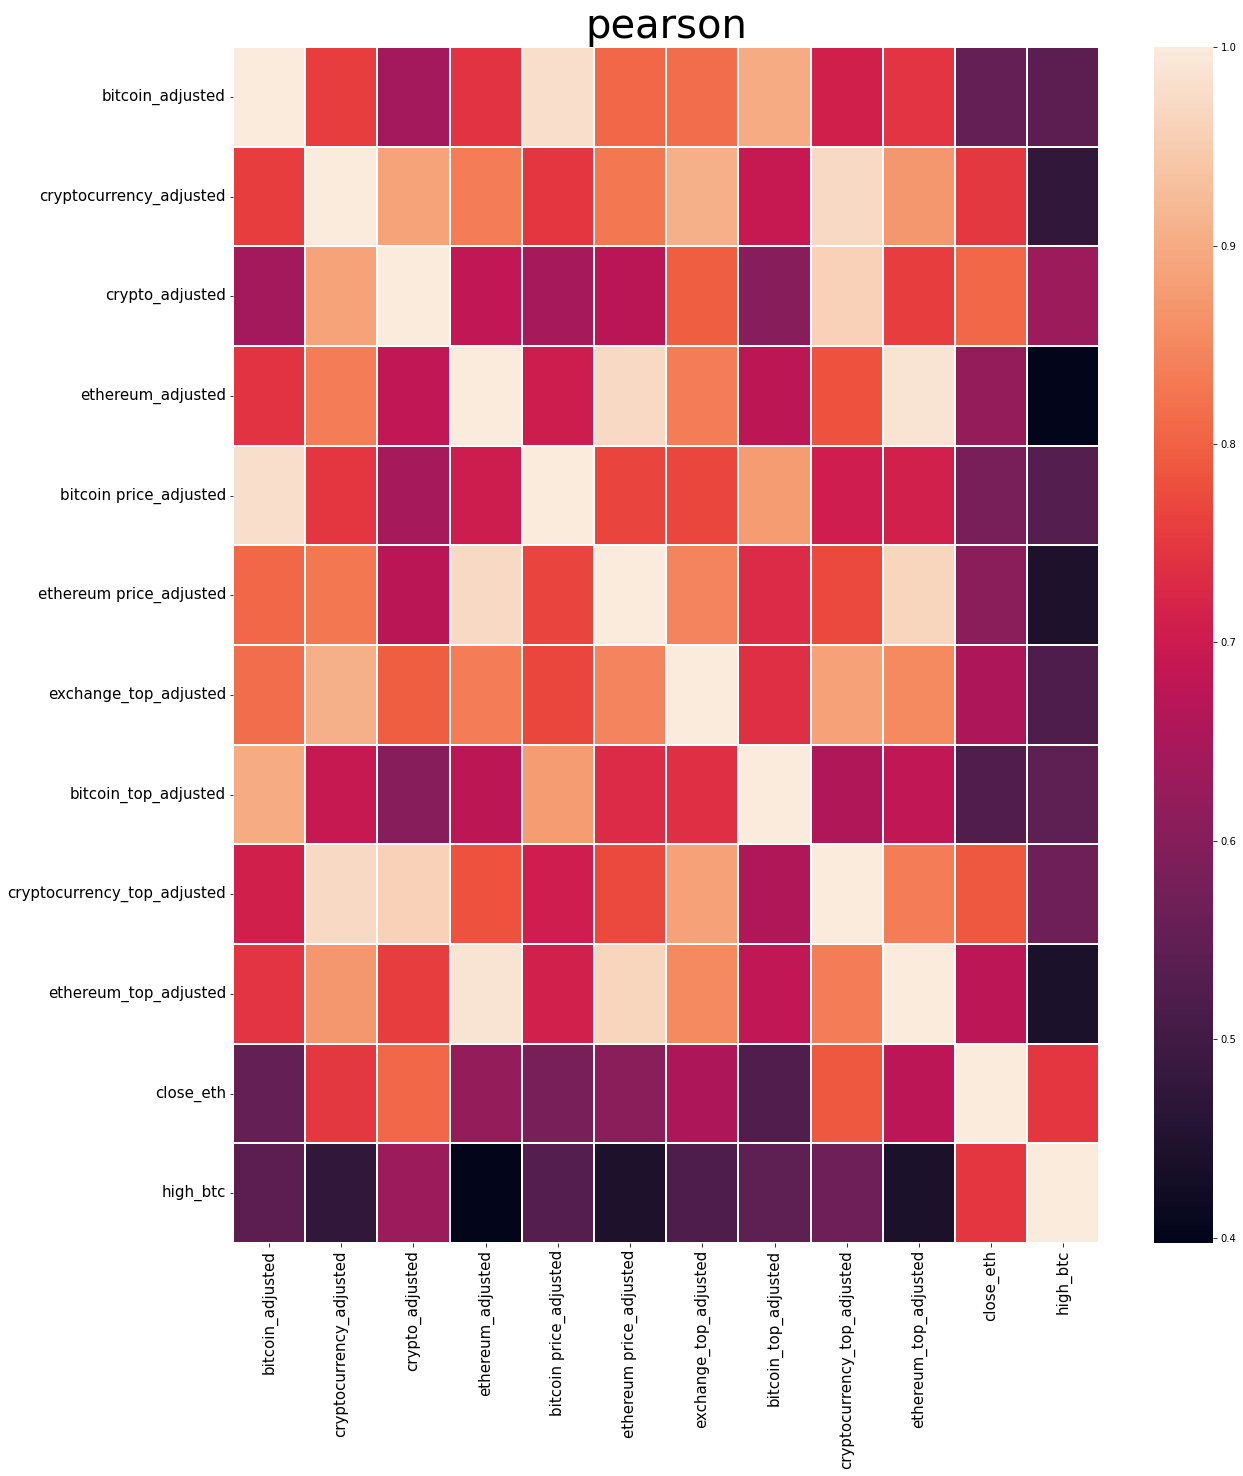

In [52]:
# seleccionamos las columnas de interés
train3 = train.loc[:,['bitcoin_adjusted', 'cryptocurrency_adjusted', 'crypto_adjusted', 'ethereum_adjusted', 'bitcoin price_adjusted', 'ethereum price_adjusted', 'exchange_top_adjusted', 'bitcoin_top_adjusted', 'cryptocurrency_top_adjusted', 'ethereum_top_adjusted','close_eth', 'high_btc']]
#generacion del grafico de correlacion
plt.figure(figsize=(66,22))
for j,i in enumerate(['pearson']):
  plt.subplot(1,3,j+1)
  correlation = train3.dropna().corr(method=i)
  sns.heatmap(correlation, linewidth = 1)
  plt.title(i, fontsize=40)
  plt.yticks(fontsize=15)
  plt.xticks(fontsize=15)

La predictora 'high_btc' no está muy correlacionada con las variables estudiadas anteriormente pero sí con 'close_eth'.
Por el contrario, 'close_eth' sí está más correlacionada con las otras variables, en particular con 'cryptocurrency_adjusted', 'crypto_adjusted' y 'cryptocurrency_top_adjusted' además de 'high_btc'.

### Gráficos de dispersión y distribución

A continuación, se realiza un análisis de dispersión entre las variables dependientes *y_lag1* e *y_lag7* (a modo de simplificación) con algunas predictoras que tienen una alta correlación lineal con los targets. En primer lugar, se grafica la asociación y distribución del precio actual de ethereum versus los dos rezagos del precio de ethereum. 

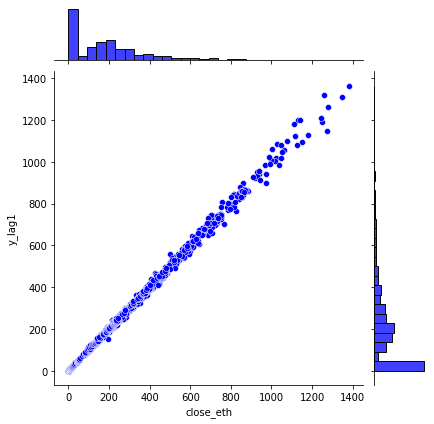

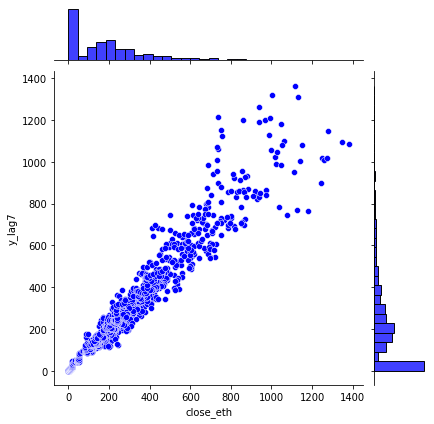

In [53]:
#Grafico usando un scatterplot y histrograma 
sns.jointplot(x = 'close_eth', y= 'y_lag1', data=train ,color='blue')
sns.jointplot(x = 'close_eth', y= 'y_lag7', data=train ,color='blue');

Los gráficos de arriba muestran que la correlación lineal altamente positiva tiene una mayor dispersión a mayor ventana de tiempo, ya que al pasar del primer al séptimo rezago del precio de ethereum los puntos se vuelven más distantes entre sí, y cuya dispersión es aún mayor al tratarse de mayores niveles de precio. Esto podría decirnos que la variabilidad del precio futuro de ethereum puede ser predicho adecuadamente con el precio presente solamente si se trata de los días futuros inmediatos (quizás los primeros tres días). Al tratarse de ventanas más distantes podrían entrar en juego otros factores que capten patrones diferentes al que identifica el precio actual de la criptomoneda bajo estudio.

En los dos gráficos siguientes se realizan los mismos plots pero utilizando el precio de apertura de bitcoin: 

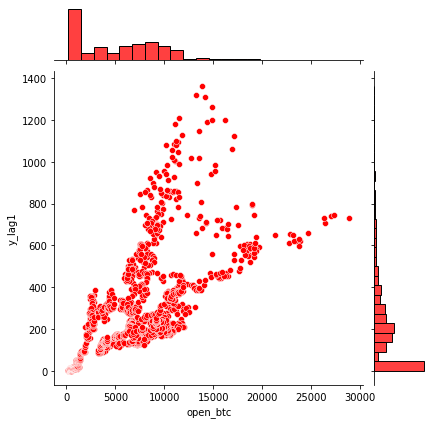

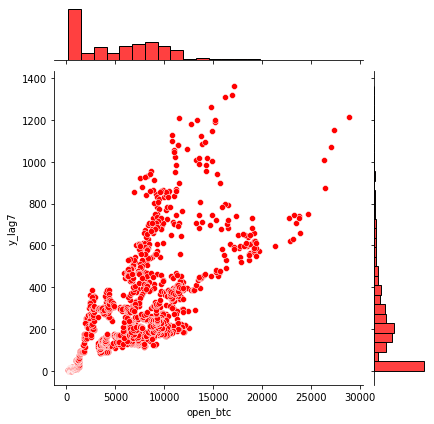

In [54]:
#Grafico usando un scatterplot y histograma 
sns.jointplot(x = 'open_btc', y= 'y_lag1', data=train ,color='red')
sns.jointplot(x = 'open_btc', y='y_lag7', data=train ,color='red');

En los gráficos de arriba, se observa una mayor dispersión que para el caso de la comparación con close_eth, lo cual era un resultado esperado debido a que la correlación entre close_eth y las variables targets es mayor que entre close_btc y los diferentes rezagos del precio de ethereum. Lo interesante radica en que la forma de la asociación entre bitcoin y el precio futuro de ethereum no varía al cambiar la ventana temporal, de hecho, como vimos en la tabla de correlaciones en la sección *target versus predictoras* la correlación entre los precios de cierre y apertura presentes de bitcoin y la cotización futura promedio de ethereum aumenta levemente a mayor ventana temporal. Debido a que la correlación de pearson capta patrones lineales, el aumento de este indicador entre rezagos del precio de ethereum podría deberse a que, una mayor cantidad de puntos se concentran en la parte inferior izquierda del gráfico, es decir, a menores precios, lo cual linealmente implica un mayor ajuste y por lo tanto un indicador de pearson mayor. No obstante, al observar las dispersiones se ve que claramente la relación no es lineal.  

Por último, realizamos el mismo ejercicio pero utilizando el término de búsqueda de google *covid-19* y lo comparamos con los rezagos del target. Las nubes de puntos junto con sus distribuciones pueden verse en los siguientes gráficos:

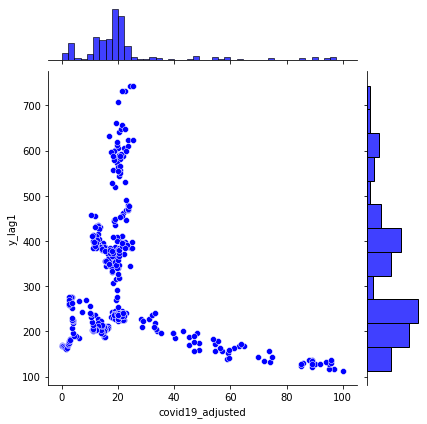

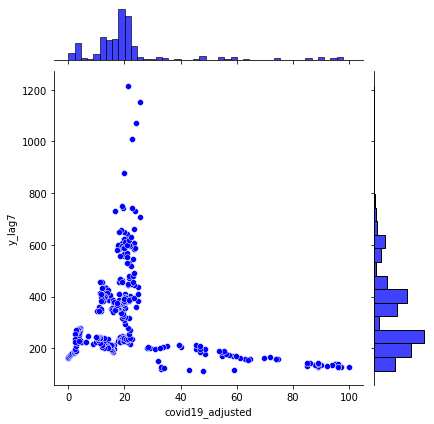

In [55]:
#Grafico usando un scatterplot y histrograma 
sns.jointplot(x = 'covid19_adjusted', y= 'y_lag1', data=train.loc[train.covid19_adjusted>0] ,color='blue')
sns.jointplot(x = 'covid19_adjusted', y= 'y_lag7', data=train.loc[train.covid19_adjusted>0] ,color='blue');

En primer lugar, se aclara que para generar los gráficos de arriba primero se filtra el primer período de la serie, donde no existían búsquedas de coronavirus. Para hacerlo solamente filtramos las filas que tiene frecuencias de búsquedas de covid positivas, ya que, como se muestra en el análisis univariado de la sección anterior, una vez generado el fenómeno la proporción de búsqueda siempre se mantuvo por encima de cero. 

En los gráficos se observa una marcada no linealidad: tanto el primer como el séptimo rezago del precio de ethereum presentan una relación elástica en el primer tramo de valores de *covid19_adjusted* e inelástica en el tramo superior de valores del predictor. En frecuencias entre 0 y 30% de la palabra covid-19 la relación presenta una pendiente lineal empinada, donde ante un aumento de un punto porcentual de la frecuencias de búsqueda de este predictor el precio de ethereum aumenta considerablemente. Mientras que al pasar a frecuencias de búsqueda de covid-19 superior al 30% la relación lineal es levemente negativa, pero casi completamente inelástica, es decir, aumentos de un punto porcentual en la búsqueda diaria de la palabra en cuestión se asocian con leves caídas en el precio futuro de ethereum.   